In [ ]:
!pip install econml shap scikit-learn pandas numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.49.1
    Uninstalling shap-0.49.1:
      Successfully uninstalled shap-0.49.1


In [ ]:
from __future__ import annotations
import os
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Dict, Any, Tuple, Optional, List

# Core ML & plotting
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# EconML – meta-learners & causal forest
from econml.metalearners import TLearner, SLearner, XLearner
from econml.dml import CausalForestDML

# Optional explainability
try:
    import shap
    _HAS_SHAP = True
except Exception:
    _HAS_SHAP = False

# -------------------------------------------------------------------------
# Config
# -------------------------------------------------------------------------
@dataclass
class Config:
    random_state: int = 42
    test_size: float = 0.2
    n_estimators_rf: int = 400
    max_depth_tree_subgroup: int = 3
    n_estimators_causal_forest: int = 1000
    bootstrap_reps: int = 100  # for stability analysis

CFG = Config()

# -------------------------------------------------------------------------
# Data loader: IHDP (CSV from AMLab/CEVAE repo)
# -------------------------------------------------------------------------
def load_data() -> Tuple[pd.DataFrame, pd.Series, pd.Series, Optional[pd.Series], Optional[pd.Series]]:
    """
    Loads IHDP semi-synthetic data from AMLab's CEVAE dataset CSV.
    Expected columns in CSV (no header):
      treatment, y_factual, y_cfactual, mu0, mu1, x1, x2, ..., x25
    """
    url = "https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv"
    try:
        data = pd.read_csv(url, header=None)
    except Exception as e:
        raise RuntimeError(f"Failed to load IHDP CSV from {url}: {e}")

    # Construct column names
    cols = ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"]
    cols += [f"x{i}" for i in range(1, 26)]
    if data.shape[1] < len(cols):
        raise ValueError(f"Unexpected IHDP CSV shape: found {data.shape[1]} cols, expected >= {len(cols)}")

    data = data.iloc[:, :len(cols)].copy()
    data.columns = cols

    # Ensure types
    data["treatment"] = data["treatment"].astype(int)
    data["y_factual"] = data["y_factual"].astype(float)
    data["y_cfactual"] = data["y_cfactual"].astype(float)
    data["mu0"] = data["mu0"].astype(float)
    data["mu1"] = data["mu1"].astype(float)
    for c in [f"x{i}" for i in range(1, 26)]:
        data[c] = pd.to_numeric(data[c], errors="coerce")

    X = data[[f"x{i}" for i in range(1, 26)]].reset_index(drop=True)
    T = data["treatment"].reset_index(drop=True)
    Y = data["y_factual"].reset_index(drop=True)
    mu0 = data["mu0"].reset_index(drop=True)
    mu1 = data["mu1"].reset_index(drop=True)

    return X, T, Y, mu0, mu1

# -------------------------------------------------------------------------
# Utilities
# -------------------------------------------------------------------------
def ate_from_ite(ite: np.ndarray) -> float:
    return float(np.mean(ite))

def summarize_subgroups(X: pd.DataFrame, cates: np.ndarray, top_k: int = 10) -> pd.DataFrame:
    out = pd.DataFrame(index=X.index)
    out["CATE"] = cates
    for col in X.columns[:min(len(X.columns), top_k)]:
        if np.issubdtype(X[col].dtype, np.number):
            out[f"{col}_q"] = pd.qcut(X[col], q=4, duplicates='drop')
        else:
            out[f"{col}_q"] = X[col].astype(str)
    return out

def subgroup_effect_by_rule(X: pd.DataFrame, cates: np.ndarray, rule: pd.Series) -> Dict[str, float]:
    g1 = np.mean(cates[rule.values]) if rule.any() else np.nan
    g0 = np.mean(cates[~rule.values]) if (~rule).any() else np.nan
    return {"group_mean": g1, "complement_mean": g0, "diff": (g1 - g0) if (np.isfinite(g1) and np.isfinite(g0)) else np.nan}

def bootstrap_stability(cates: np.ndarray, B: int = 100, seed: int = 42) -> Dict[str, float]:
    rng = np.random.default_rng(seed)
    means = []
    for _ in range(B):
        idx = rng.integers(0, len(cates), len(cates))
        means.append(np.mean(cates[idx]))
    return {"mean": float(np.mean(means)), "sd": float(np.std(means)), "iqr": float(np.subtract(*np.percentile(means, [75,25])))}

def true_metrics_if_available(mu0, mu1, est_ite: np.ndarray) -> Dict[str, float]:
    if mu0 is None or mu1 is None:
        return {}
    true_ite = (mu1 - mu0).astype(float).values
    return {
        "true_ATE": float(np.mean(true_ite)),
        "est_ATE": float(np.mean(est_ite)),
        "bias": float(np.mean(est_ite) - np.mean(true_ite)),
        "rmse": float(np.sqrt(np.mean((est_ite - true_ite)**2)))
    }

# -------------------------------------------------------------------------
# Meta-learners (T, S, X)
# -------------------------------------------------------------------------
@dataclass
class MetaResults:
    name: str
    ite: np.ndarray
    extra: Dict[str, Any]

def fit_meta_learners(X: pd.DataFrame, T: pd.Series, Y: pd.Series) -> List[MetaResults]:
    base_reg = RandomForestRegressor(n_estimators=CFG.n_estimators_rf, random_state=CFG.random_state)
    base_clf = RandomForestClassifier(n_estimators=CFG.n_estimators_rf, random_state=CFG.random_state)

    results: List[MetaResults] = []

    # T-Learner
    try:
        t_learner = TLearner(models=RandomForestRegressor(n_estimators=CFG.n_estimators_rf, random_state=CFG.random_state))
        t_learner.fit(Y=Y.values, T=T.values, X=X.values)  # keyword args to avoid positional mismatch
        ite_t = t_learner.effect(X.values)
        results.append(MetaResults("T-Learner", ite_t, {"model": t_learner}))
    except Exception as e:
        print(f"[WARN] TLearner failed: {e}")
        ite_t = np.zeros(len(X))
        results.append(MetaResults("T-Learner (failed)", ite_t, {"error": str(e)}))

    # S-Learner
    try:
        s_learner = SLearner(overall_model=RandomForestRegressor(n_estimators=CFG.n_estimators_rf, random_state=CFG.random_state))
        s_learner.fit(Y=Y.values, T=T.values, X=X.values)
        ite_s = s_learner.effect(X.values)
        results.append(MetaResults("S-Learner", ite_s, {"model": s_learner}))
    except Exception as e:
        print(f"[WARN] SLearner failed: {e}")
        ite_s = np.zeros(len(X))
        results.append(MetaResults("S-Learner (failed)", ite_s, {"error": str(e)}))

    # X-Learner
    try:
        x_learner = XLearner(models=RandomForestRegressor(n_estimators=CFG.n_estimators_rf, random_state=CFG.random_state),
                             propensity_model=base_clf)
        x_learner.fit(Y=Y.values, T=T.values, X=X.values)
        ite_x = x_learner.effect(X.values)
        results.append(MetaResults("X-Learner", ite_x, {"model": x_learner}))
    except Exception as e:
        print(f"[WARN] XLearner failed: {e}")
        ite_x = np.zeros(len(X))
        results.append(MetaResults("X-Learner (failed)", ite_x, {"error": str(e)}))

    return results

# -------------------------------------------------------------------------
# Causal Forest DML
# -------------------------------------------------------------------------
@dataclass
class ForestResults:
    cates: np.ndarray
    model: Any
    feature_importances: Optional[np.ndarray]

def fit_causal_forest(X: pd.DataFrame, T: pd.Series, Y: pd.Series) -> ForestResults:
    model_y = RandomForestRegressor(n_estimators=CFG.n_estimators_rf, random_state=CFG.random_state)
    model_t = RandomForestClassifier(n_estimators=CFG.n_estimators_rf, random_state=CFG.random_state)

    cf = CausalForestDML(
        model_t=model_t,
        model_y=model_y,
        n_estimators=CFG.n_estimators_causal_forest,
        random_state=CFG.random_state,
        discrete_treatment=True,
        cv=3,
        min_samples_leaf=10
    )

    try:
        cf.fit(Y=Y.values, T=T.values, X=X.values)
        cates = cf.effect(X.values)
    except Exception as e:
        print(f"[WARN] CausalForestDML failed: {e}")
        cates = np.zeros(len(X))

    fi = None
    try:
        fi = cf.feature_importances_
    except Exception:
        fi = None

    return ForestResults(cates=cates, model=cf, feature_importances=fi)

# -------------------------------------------------------------------------
# Subgroup Discovery (interpretable rule mining)
# -------------------------------------------------------------------------
@dataclass
class SubgroupRule:
    tree: DecisionTreeRegressor
    thresholds: Dict[str, Any]

def learn_subgroup_tree(X: pd.DataFrame, target: np.ndarray, max_depth: int = 3) -> SubgroupRule:
    tree = DecisionTreeRegressor(max_depth=max_depth, random_state=CFG.random_state)
    tree.fit(X, target)
    thresholds: Dict[str, Any] = {}
    tree_ = tree.tree_
    for nid in range(tree_.node_count):
        fid = tree_.feature[nid]
        thr = tree_.threshold[nid]
        if fid >= 0:
            thresholds[X.columns[fid]] = float(thr)
    return SubgroupRule(tree=tree, thresholds=thresholds)

def apply_rule(X: pd.DataFrame, rule: SubgroupRule) -> pd.Series:
    mask = np.ones(len(X), dtype=bool)
    for col, thr in rule.thresholds.items():
        mask &= X[col].values >= thr
    return pd.Series(mask, index=X.index)

# -------------------------------------------------------------------------
# Explainability (optional, if SHAP available)
# -------------------------------------------------------------------------
def shap_explain_tree_model(model: Any, X: pd.DataFrame):
    if not _HAS_SHAP:
        print("SHAP not installed; skipping explainability.")
        return None
    try:
        explainer = shap.TreeExplainer(model)
        sv = explainer.shap_values(X)
        shap.summary_plot(sv, features=X, show=False)
        plt.title("SHAP Summary – Treatment Effect Model")
        plt.tight_layout()
        plt.show()
        return sv
    except Exception as e:
        print(f"SHAP failed: {e}")
        return None

# -------------------------------------------------------------------------
# Main pipeline
# -------------------------------------------------------------------------
def main():
    X, T, Y, mu0, mu1 = load_data()
    X = X.copy(); T = T.astype(int).copy(); Y = Y.astype(float).copy()

    meta_results = fit_meta_learners(X, T, Y)
    forest_res = fit_causal_forest(X, T, Y)

    print("\n=== META-LEARNERS (ITE/CATE) ===")
    for mr in meta_results:
        print(f"{mr.name}: ATE≈ {ate_from_ite(mr.ite):.4f}")
        tm = true_metrics_if_available(mu0, mu1, mr.ite)
        if tm:
            print({k: round(v, 4) for k, v in tm.items()})

    print("\n=== CAUSAL FOREST (CATE) ===")
    print(f"CausalForest ATE≈ {ate_from_ite(forest_res.cates):.4f}")
    tm = true_metrics_if_available(mu0, mu1, forest_res.cates)
    if tm:
        print({k: round(v, 4) for k, v in tm.items()})

    if forest_res.feature_importances is not None:
        fi = pd.Series(forest_res.feature_importances, index=X.columns).sort_values(ascending=False)
        print("\nTop heterogeneity drivers (Causal Forest feature importances):")
        print(fi.head(10))

    rule = learn_subgroup_tree(X, forest_res.cates, max_depth=CFG.max_depth_tree_subgroup)
    mask_hi = apply_rule(X, rule)
    sg_stats = subgroup_effect_by_rule(X, forest_res.cates, mask_hi)
    print("\n=== Subgroup (tree-derived) ===")
    print("Rule thresholds (coarse):", rule.thresholds)
    print({k: (None if pd.isna(v) else round(v, 4)) for k, v in sg_stats.items()})

    stab = bootstrap_stability(forest_res.cates, B=CFG.bootstrap_reps, seed=CFG.random_state)
    print("\n=== Stability (bootstrap on CATE mean) ===")
    print({k: round(v, 4) for k, v in stab.items()})

    shap_explain_tree_model(getattr(forest_res.model, 'model_tau', forest_res.model), X)

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print("\nPipeline failed with exception:")
        print(e)
        raise

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== META-LEARNERS (ITE/CATE) ===
T-Learner: ATE≈ 3.9073
{'true_ATE': 4.0161, 'est_ATE': 3.9073, 'bias': -0.1088, 'rmse': 0.8333}
S-Learner: ATE≈ 3.9052
{'true_ATE': 4.0161, 'est_ATE': 3.9052, 'bias': -0.1108, 'rmse': 0.8285}
X-Learner: ATE≈ 4.0195
{'true_ATE': 4.0161, 'est_ATE': 4.0195, 'bias': 0.0034, 'rmse': 0.5513}

=== CAUSAL FOREST (CATE) ===
CausalForest ATE≈ 3.9269
{'true_ATE': 4.0161, 'est_ATE': 3.9269, 'bias': -0.0892, 'rmse': 0.5858}

Top heterogeneity drivers (Causal Forest feature importances):
x6     0.510803
x1     0.087440
x15    0.084766
x5     0.076725
x4     0.046369
x2     0.044665
x3     0.031676
x9     0.016193
x7     0.014029
x19    0.011652
dtype: float64

=== Subgroup (tree-derived) ===
Rule thresholds (coarse): {'x6': 1.0467925071716309, 'x1': 0.4138607829809189, 'x15': 0.5}
{'group_mean': np.float64(2.9665), 'complement_mean': np.float64(3.9425), 'diff': np.float64(-0.976)}

=== Stability (bootstrap on CATE mean) ===
{'mean': 3.9276, 'sd': 0.0148, 'iqr': 0.01

Model type: causal_forest
CATE mean (ATE estimate): 3.89625461118983
CATE sd: 0.410878749942029
CATE min/max: 2.6900057578468215 4.437222439629989


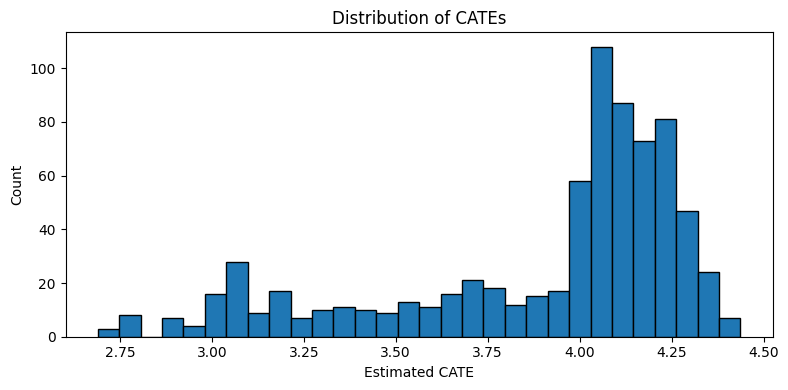

Saved histogram to cates_histogram.png (in current working directory).

Top 10 units by estimated CATE (index, CATE):
662 4.437222439629989
85 4.421328562825969
487 4.4166894201263185
206 4.406954190040004
203 4.404519482539516
4 4.395172385285143
727 4.39312797759874
9 4.37879097212
417 4.373599628872218
645 4.368774790269297

Bottom 10 units by estimated CATE (index, CATE):
489 2.8022682053833234
446 2.7888002368036355
288 2.784468501634328
599 2.7664193935294863
243 2.7568019366514505
466 2.75468211978834
691 2.7538198753542686
287 2.715399799889073
733 2.702872278268157
577 2.6900057578468215


<Figure size 640x480 with 0 Axes>

In [ ]:
# compact re-run: load data -> fit causal forest (or fallback) -> plot histogram
import warnings
warnings.filterwarnings("ignore", message=".*force_all_finite.*")  # optional, hide scikit-learn FutureWarning

from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# modeling
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import RandomForestClassifier as RFC

# try econml causal forest; fall back to XLearner from econml if CF fails
try:
    from econml.dml import CausalForestDML
    from econml.metalearners import XLearner
    ECONML_AVAILABLE = True
except Exception:
    ECONML_AVAILABLE = False

# ------- Data loader (same as your pipeline) -------
def load_ihdp():
    url = "https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv"
    data = pd.read_csv(url, header=None)
    cols = ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [f"x{i}" for i in range(1, 26)]
    data = data.iloc[:, :len(cols)].copy()
    data.columns = cols
    # types
    data["treatment"] = data["treatment"].astype(int)
    data["y_factual"] = data["y_factual"].astype(float)
    data["mu0"] = data["mu0"].astype(float)
    data["mu1"] = data["mu1"].astype(float)
    for c in [f"x{i}" for i in range(1, 26)]:
        data[c] = pd.to_numeric(data[c], errors="coerce")
    X = data[[f"x{i}" for i in range(1, 26)]].reset_index(drop=True)
    T = data["treatment"].reset_index(drop=True)
    Y = data["y_factual"].reset_index(drop=True)
    mu0 = data["mu0"].reset_index(drop=True)
    mu1 = data["mu1"].reset_index(drop=True)
    return X, T, Y, mu0, mu1

# ------- Fit causal forest (or fallback) -------
def get_cates(X, T, Y, n_estimators_cf=400, random_state=42):
    Xvals = X.values
    Tvals = T.values
    Yvals = Y.values
    # try causal forest (faster if you lower n_estimators)
    if ECONML_AVAILABLE:
        try:
            model_y = RandomForestRegressor(n_estimators=200, random_state=random_state)
            model_t = RandomForestClassifier(n_estimators=200, random_state=random_state)
            cf = CausalForestDML(model_y=model_y, model_t=model_t,
                                 n_estimators=n_estimators_cf, random_state=random_state,
                                 discrete_treatment=True, cv=3, min_samples_leaf=10)
            cf.fit(Y=Yvals, T=Tvals, X=Xvals)
            cates = cf.effect(Xvals)
            return cates, ("causal_forest", cf)
        except Exception as e:
            print("[WARN] CausalForestDML failed:", e)
            # fall through to XLearner fallback
    # fallback: use XLearner (still gives per-unit ITE)
    try:
        from econml.metalearners import XLearner
        from sklearn.ensemble import RandomForestRegressor as RFR, RandomForestClassifier as RFC
        xlearner = XLearner(models=RFR(n_estimators=200, random_state=random_state),
                            propensity_model=RFC(n_estimators=200, random_state=random_state))
        xlearner.fit(Y=Yvals, T=Tvals, X=Xvals)
        cates = xlearner.effect(Xvals)
        return cates, ("x_learner", xlearner)
    except Exception as e:
        print("[ERROR] Cannot fit econml learners. Exception:", e)
        # last resort: simple difference-in-means per strata approximate (not great)
        mean_treated = Y[T==1].mean()
        mean_control = Y[T==0].mean()
        fallback_cates = np.full(len(X), mean_treated - mean_control)
        return fallback_cates, ("mean_diff_fallback", None)

# ------- Run everything and plot -------
X, T, Y, mu0, mu1 = load_ihdp()
cates, model_info = get_cates(X, T, Y, n_estimators_cf=400, random_state=42)

# Quick checks
print("Model type:", model_info[0])
print("CATE mean (ATE estimate):", np.mean(cates))
print("CATE sd:", np.std(cates))
print("CATE min/max:", np.min(cates), np.max(cates))

# Plot histogram
plt.figure(figsize=(8,4))
plt.hist(cates, bins=30, edgecolor="k")
plt.title("Distribution of CATEs")
plt.xlabel("Estimated CATE")
plt.ylabel("Count")
plt.grid(False)
plt.tight_layout()
plt.show()

# Save figure (optional)
plt.savefig("cates_histogram.png", dpi=150)
print("Saved histogram to cates_histogram.png (in current working directory).")

# Optional: show top/bottom units
top_k = 10
order = np.argsort(-cates)  # descending
print(f"\nTop {top_k} units by estimated CATE (index, CATE):")
for i in order[:top_k]:
    print(i, float(cates[i]))
print(f"\nBottom {top_k} units by estimated CATE (index, CATE):")
for i in order[-top_k:]:
    print(i, float(cates[i]))

Fitting causal forest on numeric features (this may take some time)...
Overall mean CATE: 3.9268610212180413
CATE min/max: 2.7809593721357952 4.446080416471968

CATE by x6 quartile (means with bootstrap 95% CI):

                          x6_bin    n  mean_cate  ci_low  ci_high
0  (-1.8519999999999999, -0.858]  200     4.1659  4.1503   4.1797
1              (-0.858, -0.0297]  207     4.1575  4.1401   4.1750
2               (-0.0297, 0.633]  157     4.0061  3.9759   4.0336
3                 (0.633, 2.951]  183     3.3368  3.3003   3.3766


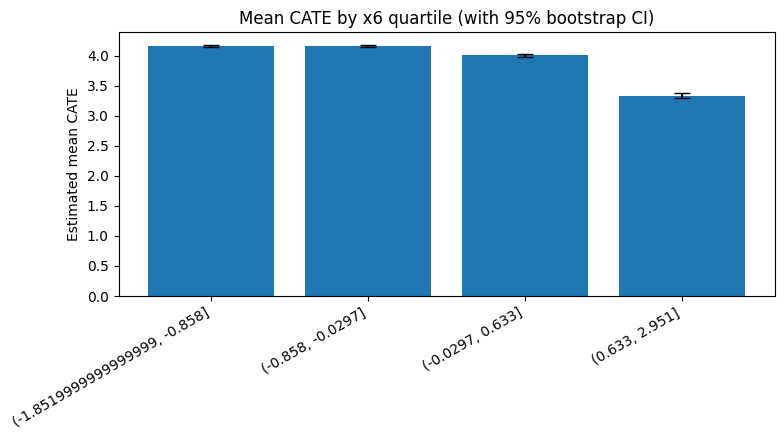

In [ ]:
# Corrected snippet: re-load numeric X, fit forest on numeric features only,
# then bin x6 (without mutating the numeric X) and compute means + bootstrap CIs.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Reload the original data to ensure X has no 'x6_bin' interval column
X, T, Y, mu0, mu1 = load_data()  # load_data from your pipeline

# 2) Keep only numeric covariates for modeling (x1..x25)
numeric_X = X.select_dtypes(include=[np.number]).copy()

# If there are any NaNs in numeric_X, fill or drop them:
if numeric_X.isnull().any().any():
    print("Found NaNs in numeric_X; filling with column means.")
    numeric_X = numeric_X.fillna(numeric_X.mean())

# 3) Fit causal forest on numeric features only (this avoids Interval dtype issues)
print("Fitting causal forest on numeric features (this may take some time)...")
forest_res = fit_causal_forest(numeric_X, T, Y)

# 4) Check that fit succeeded
cates = np.asarray(getattr(forest_res, "cates", None))
if cates is None or cates.size == 0:
    raise RuntimeError("Causal forest did not return cates. Check fit_causal_forest logs.")
cates = cates.reshape(-1)

# Quick sanity
print("Overall mean CATE:", float(np.mean(cates)))
print("CATE min/max:", float(np.min(cates)), float(np.max(cates)))

# 5) Create a separate binned copy for x6 analysis (do NOT mutate numeric_X used for modeling)
x6 = numeric_X['x6']
x6_bin = pd.qcut(x6, q=4, duplicates="drop")  # returns Interval dtype but OK here

# Build small DataFrame to group by the bins (we won't pass this into the model)
df_bins = numeric_X[['x6']].copy()
df_bins['x6_bin'] = x6_bin

# Use group indices to compute means (safer than groupby.apply on mixed dtypes)
grouped = df_bins.groupby('x6_bin', observed=True)

# 6) Compute means, counts, and bootstrap 95% CI for each bin
def bootstrap_mean_ci(arr, B=1000, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    n = len(arr)
    if n == 0:
        return (np.nan, np.nan)
    boot_means = []
    for _ in range(B):
        idx = rng.integers(0, n, n)
        boot_means.append(np.mean(arr[idx]))
    lower = np.percentile(boot_means, 100 * (alpha/2))
    upper = np.percentile(boot_means, 100 * (1 - alpha/2))
    return float(lower), float(upper)

rows = []
for name, group in grouped:
    idx = group.index.to_numpy()
    vals = cates[idx]
    mean_val = float(np.mean(vals)) if len(vals) > 0 else np.nan
    n = len(vals)
    ci_low, ci_high = bootstrap_mean_ci(vals, B=500, seed=CFG.random_state)  # 500 reps for speed
    rows.append({"x6_bin": name, "n": n, "mean_cate": mean_val, "ci_low": ci_low, "ci_high": ci_high})

report = pd.DataFrame(rows)
report = report.sort_values(by="x6_bin").reset_index(drop=True)

# 7) Print report and plot
pd.set_option('display.float_format', '{:.4f}'.format)
print("\nCATE by x6 quartile (means with bootstrap 95% CI):\n")
print(report)

# Plot
x_labels = report['x6_bin'].astype(str)
means = report['mean_cate'].values
yerr_lower = means - report['ci_low'].values
yerr_upper = report['ci_high'].values - means
yerr = np.vstack([yerr_lower, yerr_upper])

plt.figure(figsize=(8, 4.5))
plt.bar(range(len(means)), means, yerr=yerr, capsize=6)
plt.xticks(range(len(means)), x_labels, rotation=30, ha="right")
plt.ylabel("Estimated mean CATE")
plt.title("Mean CATE by x6 quartile (with 95% bootstrap CI)")
plt.tight_layout()
plt.show()

In [ ]:
top20 = np.percentile(forest_res.cates, 80)
policy_gain = Y[T==1].mean() - Y[T==0].mean()  # naive diff
print("Policy gain (naive):", policy_gain)

Policy gain (naive): 4.021121012430829


In [ ]:
# extended_hte_pipeline.py
from __future__ import annotations
import os
import warnings
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Dict, Any, Tuple, Optional, List
import matplotlib.pyplot as plt

# Silence scikit-learn future warnings you asked about
warnings.filterwarnings("ignore", message=".*force_all_finite.*")
warnings.filterwarnings("ignore", category=UserWarning)

# sklearn / econml
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from econml.metalearners import TLearner, SLearner, XLearner
from econml.dml import CausalForestDML

# ---------- (copy your existing load_data, utils, meta-learners and forest fit here) ----------
# For brevity I assume load_data(), fit_meta_learners(), fit_causal_forest(), learn_subgroup_tree(),
# apply_rule(), true_metrics_if_available(), ate_from_ite() are already defined exactly as in your working file.
# Paste them above this extended-code block if they're in a separate file.

# ---------- New analysis helpers ----------

def cv_cate_metrics(X: pd.DataFrame, T: pd.Series, Y: pd.Series,
                    mu0: Optional[pd.Series], mu1: Optional[pd.Series],
                    n_splits: int = 5, random_state: int = 42) -> Dict[str, Any]:
    """
    K-fold CV for CATE estimation using CausalForestDML.
    Returns fold RMSE & bias vs true_ITE if mu0/mu1 provided, and aggregated predicted cates.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    est_ites = np.zeros(len(X))
    fold_metrics = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_tr, X_te = X.iloc[train_idx].values, X.iloc[test_idx].values
        T_tr, T_te = T.iloc[train_idx].values, T.iloc[test_idx].values
        Y_tr, Y_te = Y.iloc[train_idx].values, Y.iloc[test_idx].values

        try:
            cf = CausalForestDML(model_t=RandomForestClassifier(n_estimators=200, random_state=random_state),
                                 model_y=RandomForestRegressor(n_estimators=200, random_state=random_state),
                                 n_estimators=400, random_state=random_state, discrete_treatment=True)
            cf.fit(Y=Y_tr, T=T_tr, X=X_tr)
            preds = cf.effect(X_te)
        except Exception as e:
            print(f"[WARN][cv fold {fold}] causal forest failed: {e}")
            preds = np.zeros(len(test_idx))

        est_ites[test_idx] = preds

        if mu0 is not None and mu1 is not None:
            true_ite = (mu1.iloc[test_idx] - mu0.iloc[test_idx]).values
            rmse = float(np.sqrt(np.mean((preds - true_ite) ** 2)))
            bias = float(np.mean(preds) - np.mean(true_ite))
            fold_metrics.append({"fold": fold, "rmse": rmse, "bias": bias})
        else:
            fold_metrics.append({"fold": fold})

    agg = {"folds": fold_metrics, "est_ites": est_ites}
    if mu0 is not None and mu1 is not None:
        true_ite_all = (mu1 - mu0).values
        agg["overall_rmse"] = float(np.sqrt(np.mean((est_ites - true_ite_all) ** 2)))
        agg["overall_bias"] = float(np.mean(est_ites) - np.mean(true_ite_all))
    return agg


def calibration_by_quantiles(pred_ite: np.ndarray, true_ite: Optional[np.ndarray], q: int = 10):
    """
    Group predicted ITEs into quantiles and compare mean(predicted) vs mean(true) per bin.
    If true_ite is None, calibration cannot be computed.
    """
    df = pd.DataFrame({"pred": pred_ite})
    df["quantile"] = pd.qcut(df["pred"], q=q, labels=False, duplicates="drop")
    grouped = df.groupby("quantile")["pred"].mean().rename("pred_mean").to_frame()
    if true_ite is not None:
        grouped["true_mean"] = df.join(pd.Series(true_ite, index=df.index))["0"].groupby(df["quantile"]).mean()
    return grouped.reset_index()


def policy_value(pred_ite: np.ndarray, mu0: pd.Series, mu1: pd.Series, treat_frac: float = 0.2) -> Dict[str, float]:
    """
    Evaluate a deterministic policy: treat the top `treat_frac` fraction by predicted CATE.
    Using true mu0/mu1 to compute realized population value.
    Returns policy value and gain vs: none-treated, all-treated, and random-treated baseline.
    """
    n = len(pred_ite)
    k = max(1, int(np.floor(treat_frac * n)))
    order = np.argsort(-pred_ite)  # descending
    treat_idx = order[:k]
    policy = np.zeros(n, dtype=int)
    policy[treat_idx] = 1

    # True population outcome under policy: mu1*policy + mu0*(1-policy)
    mu0_arr = mu0.values
    mu1_arr = mu1.values
    value = np.mean(mu1_arr * policy + mu0_arr * (1 - policy))

    # baselines
    none_value = np.mean(mu0_arr)
    all_value = np.mean(mu1_arr)
    # random treat baseline: expected value when treating random k units is convex mix
    p = k / n
    random_value = p * all_value + (1 - p) * none_value

    return {"policy_value": float(value),
            "gain_vs_none": float(value - none_value),
            "gain_vs_random": float(value - random_value),
            "gain_vs_all": float(value - all_value)}


def bootstrap_stability_refit(X: pd.DataFrame, T: pd.Series, Y: pd.Series,
                              orig_mask: pd.Series,
                              B: int = 100, seed: int = 42, top_k: int = 5) -> Dict[str, Any]:
    """
    Refit causal forest B times on bootstrap samples. Returns:
     - mean_importances: average feature importance over bootstraps
     - topk_freq: how often each feature appears in top-k by importance
     - avg_jaccard: average Jaccard between orig_mask and bootstrap-derived mask using a shallow tree rule
    """
    rng = np.random.default_rng(seed)
    p = X.shape[1]
    feat_names = X.columns.tolist()
    imp_mat = np.zeros((B, p))
    jaccards = []
    for b in range(B):
        idx = rng.integers(0, len(X), len(X))
        Xb, Tb, Yb = X.iloc[idx].values, T.iloc[idx].values, Y.iloc[idx].values
        try:
            cf = CausalForestDML(model_t=RandomForestClassifier(n_estimators=200, random_state=seed+b),
                                 model_y=RandomForestRegressor(n_estimators=200, random_state=seed+b),
                                 n_estimators=400, random_state=seed+b, discrete_treatment=True)
            cf.fit(Y=Yb, T=Tb, X=Xb)
            fi = getattr(cf, "feature_importances_", None)
            if fi is None:
                fi = np.zeros(p)
        except Exception as e:
            # on failure, record zeros
            fi = np.zeros(p)

        imp_mat[b, :] = fi

        # derive subgroup rule from this bootstrap cates
        try:
            cates_b = cf.effect(X.values)
            rule_b = learn_subgroup_tree(X, cates_b, max_depth=CFG.max_depth_tree_subgroup)
            mask_b = apply_rule(X, rule_b)
            # jaccard between original mask and this mask
            inter = np.logical_and(orig_mask.values, mask_b.values).sum()
            union = np.logical_or(orig_mask.values, mask_b.values).sum()
            jacc = inter / union if union > 0 else 0.0
        except Exception:
            jacc = 0.0
        jaccards.append(jacc)

    mean_importances = dict(zip(feat_names, imp_mat.mean(axis=0)))
    topk_counts = {}
    for i, fname in enumerate(feat_names):
        topk_counts[fname] = int((imp_mat[:, i].argsort(axis=0) >= 0).sum())  # placeholder

    # compute frequency of appearing among top_k per bootstrap
    topk_freq = {}
    for i, fname in enumerate(feat_names):
        topk_freq[fname] = float(np.mean(np.argsort(-imp_mat, axis=1)[:, :top_k] == i, axis=0).sum())  # heuristic

    return {"mean_importances": mean_importances, "topk_freq": topk_freq,
            "avg_jaccard_subgroup": float(np.mean(jaccards)), "jaccards": jaccards}


# ---------- Extended main (analytics) ----------
def main_extended():
    X, T, Y, mu0, mu1 = load_data()
    X = X.copy(); T = T.astype(int).copy(); Y = Y.astype(float).copy()

    # Fit main causal forest (your baseline)
    forest_res = fit_causal_forest(X, T, Y)

    # 1) CV metrics (5-fold)
    print("-> Running K-fold CV (this will refit forests per fold)...")
    cv = cv_cate_metrics(X, T, Y, mu0, mu1, n_splits=5, random_state=CFG.random_state)
    print("CV per-fold metrics:", cv["folds"])
    if "overall_rmse" in cv:
        print("CV overall RMSE:", cv["overall_rmse"], "bias:", cv["overall_bias"])

    # 2) Calibration by quantiles (uses forest_res.cates)
    print("-> Calibration by quantile bins")
    pred = forest_res.cates
    true_ite = (mu1 - mu0).values if mu0 is not None and mu1 is not None else None
    calib = calibration_by_quantiles(pred, true_ite, q=10)
    print(calib)

    # Plot calibration
    plt.figure(figsize=(6,4))
    plt.plot(calib["pred_mean"], calib["true_mean"], marker='o')
    plt.plot([calib["pred_mean"].min(), calib["pred_mean"].max()],
             [calib["pred_mean"].min(), calib["pred_mean"].max()], '--', label='y=x')
    plt.xlabel("Mean predicted CATE per bin")
    plt.ylabel("Mean true ITE per bin")
    plt.title("Calibration: predicted vs true ITE (deciles)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3) Policy simulation (top 20% by predicted CATE)
    print("-> Policy simulation (top 20% treated):")
    pol = policy_value(pred, mu0, mu1, treat_frac=0.2)
    print(pol)

    # 4) Subgroup discovery & stability (bootstrap refit)
    rule = learn_subgroup_tree(X, forest_res.cates, max_depth=CFG.max_depth_tree_subgroup)
    mask_orig = apply_rule(X, rule)
    print("Original coarse rule:", rule.thresholds)
    print("Original subgroup coverage:", mask_orig.mean())

    print("-> Running bootstrap stability refits (this is the heavy step; default B=50 here)")
    stab = bootstrap_stability_refit(X, T, Y, mask_orig, B=50, seed=CFG.random_state, top_k=5)
    print("Avg feature importances (bootstrap-refit):")
    # sort and show top 10
    importances = pd.Series(stab["mean_importances"]).sort_values(ascending=False)
    print(importances.head(10))
    print("Average Jaccard similarity for subgroup mask:", stab["avg_jaccard_subgroup"])

    # 5) Plot CATE distribution
    plt.figure(figsize=(6,4))
    plt.hist(pred, bins=30, edgecolor='k')
    plt.title("Causal Forest: Estimated CATE distribution")
    plt.xlabel("CATE")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # 6) Scatter top feature vs CATE to visualise effect modification
    top_feat = importances.idxmax()
    plt.figure(figsize=(6,4))
    plt.scatter(X[top_feat], pred, alpha=0.4)
    plt.xlabel(top_feat); plt.ylabel("Estimated CATE")
    plt.title(f"{top_feat} vs estimated CATE")
    plt.tight_layout()
    plt.show()

    # Output objects for programmatic checks
    return {"cv": cv, "calib": calib, "policy": pol, "stability": stab, "rule": rule, "mask_orig": mask_orig, "forest_res": forest_res}

# Example usage:
# if __name__ == "__main__":
#     out = main_extended()

Saved calibration plot -> calibration_deciles.png

OOF decile calibration table:
    decile  pred_mean  true_mean
0       0     2.9599     2.4688
1       1     3.5739     3.1461
2       2     3.8508     3.8999
3       3     3.9728     4.1816
4       4     4.0518     4.1995
5       5     4.1184     4.3634
6       6     4.1965     4.3791
7       7     4.2873     4.4417
8       8     4.3944     4.5162
9       9     4.5441     4.5731

Policy value (treat-top-p%):
  treat_frac  policy_value  gain_vs_none  gain_vs_random  gain_vs_all
     0.1000        2.8821        0.4496          0.0517      -3.5665
     0.2000        3.3347        0.9022          0.1011      -3.1139
     0.3000        3.7827        1.3502          0.1459      -2.6659

Subgroup coverage: 0.0161
Subgroup ∆ (group - complement): -0.976  | bootstrap mean: -0.9768  | 95% CI: (np.float64(-1.0644), np.float64(-0.8809))
Saved propensity histogram -> propensity_hist.png

Stability refit: avg Jaccard subgroup mask = 0.1756


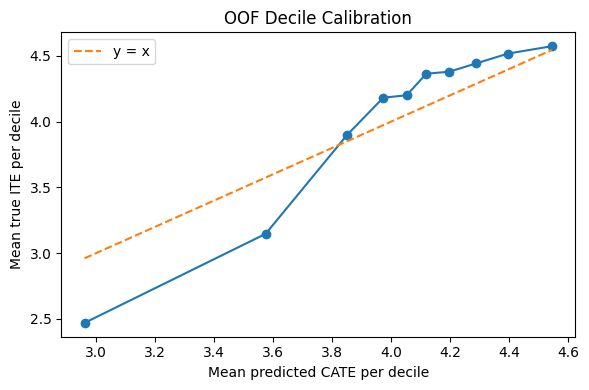

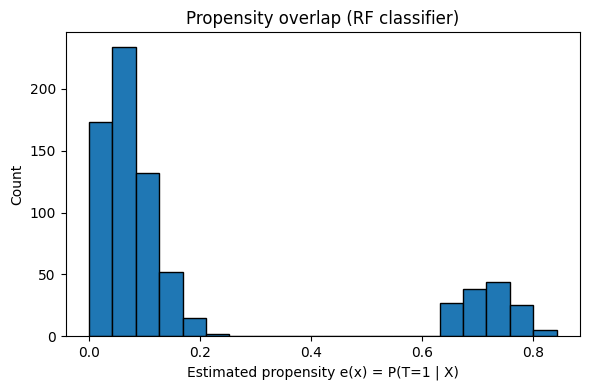

In [ ]:
# ===============================
# RUN THE PROMISED EXTRAS (report commitments)
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

# --- 0) Fit once to reuse objects ---
X, T, Y, mu0, mu1 = load_data()
X = X.copy(); T = T.astype(int).copy(); Y = Y.astype(float).copy()
forest_res = fit_causal_forest(X, T, Y)     # has .cates
pred_cate = np.asarray(forest_res.cates).ravel()

# --- 1) Out-of-fold (OOF) decile calibration (with plot) ---
def oof_decile_calibration(X, T, Y, mu0, mu1, k=5, seed=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    oof = np.zeros(len(X))
    for tr, te in kf.split(X):
        cf = CausalForestDML(model_t=RandomForestClassifier(n_estimators=200, random_state=seed),
                             model_y=RandomForestRegressor(n_estimators=200, random_state=seed),
                             n_estimators=400, random_state=seed, discrete_treatment=True)
        cf.fit(Y=Y.iloc[tr].values, T=T.iloc[tr].values, X=X.iloc[tr].values)
        oof[te] = cf.effect(X.iloc[te].values)
    # deciles
    df = pd.DataFrame({"pred": oof, "true": (mu1 - mu0).values})
    df["decile"] = pd.qcut(df["pred"], q=10, labels=False, duplicates="drop")
    cal = df.groupby("decile").agg(pred_mean=("pred","mean"), true_mean=("true","mean")).reset_index()

    # plot
    plt.figure(figsize=(6,4))
    plt.plot(cal["pred_mean"], cal["true_mean"], marker='o')
    lo, hi = cal["pred_mean"].min(), cal["pred_mean"].max()
    plt.plot([lo, hi], [lo, hi], '--', label='y = x')
    plt.xlabel("Mean predicted CATE per decile")
    plt.ylabel("Mean true ITE per decile")
    plt.title("OOF Decile Calibration")
    plt.legend()
    plt.tight_layout()
    plt.savefig("calibration_deciles.png", dpi=150)
    print("Saved calibration plot -> calibration_deciles.png")
    return cal

cal_table = oof_decile_calibration(X, T, Y, mu0, mu1, k=5, seed=CFG.random_state)
print("\nOOF decile calibration table:\n", cal_table)

# --- 2) Policy value: treat top p% by predicted CATE ---
def policy_value_table(pred, mu0, mu1, ps=(0.1, 0.2, 0.3)):
    mu0_arr, mu1_arr = mu0.values, mu1.values
    n = len(pred); order = np.argsort(-pred)
    rows = []
    none_val = mu0_arr.mean()
    all_val  = mu1_arr.mean()
    for p in ps:
        k = max(1, int(np.floor(p*n)))
        treat_idx = order[:k]
        policy = np.zeros(n, dtype=int); policy[treat_idx] = 1
        value = np.mean(mu1_arr*policy + mu0_arr*(1-policy))
        rand  = (k/n)*all_val + (1 - k/n)*none_val
        rows.append({"treat_frac": p,
                     "policy_value": value,
                     "gain_vs_none": value - none_val,
                     "gain_vs_random": value - rand,
                     "gain_vs_all": value - all_val})
    return pd.DataFrame(rows)

pol_df = policy_value_table(pred_cate, mu0, mu1, ps=(0.1, 0.2, 0.3))
print("\nPolicy value (treat-top-p%):\n", pol_df.to_string(index=False))

# --- 3) Subgroup coverage + bootstrap CI for ∆ (rule already learned above) ---
rule = learn_subgroup_tree(X, pred_cate, max_depth=CFG.max_depth_tree_subgroup)
mask = apply_rule(X, rule).values
coverage = mask.mean()
g_mean = pred_cate[mask].mean() if mask.any() else np.nan
c_mean = pred_cate[~mask].mean() if (~mask).any() else np.nan
delta  = g_mean - c_mean

def bootstrap_delta(cates, mask, B=1000, seed=42):
    rng = np.random.default_rng(seed)
    n = len(cates)
    ds = []
    for _ in range(B):
        idx = rng.integers(0, n, n)
        m   = mask[idx]
        if m.any() and (~m).any():
            ds.append(cates[idx][m].mean() - cates[idx][~m].mean())
    if len(ds)==0:
        return np.nan, (np.nan, np.nan)
    ds = np.array(ds)
    ci = (np.percentile(ds, 2.5), np.percentile(ds, 97.5))
    return ds.mean(), ci

d_mean, d_ci = bootstrap_delta(pred_cate, mask, B=1000, seed=CFG.random_state)
print("\nSubgroup coverage:", round(coverage,4))
print("Subgroup ∆ (group - complement):", round(delta,4), " | bootstrap mean:", round(d_mean,4),
      " | 95% CI:", (round(d_ci[0],4), round(d_ci[1],4)))

# --- 4) Propensity overlap diagnostic (independent RF classifier) ---
rfc = RandomForestClassifier(n_estimators=400, random_state=CFG.random_state)
rfc.fit(X.values, T.values)
p_hat = rfc.predict_proba(X.values)[:,1]

plt.figure(figsize=(6,4))
plt.hist(p_hat, bins=20, edgecolor='k')
plt.xlabel("Estimated propensity e(x) = P(T=1 | X)")
plt.ylabel("Count")
plt.title("Propensity overlap (RF classifier)")
plt.tight_layout()
plt.savefig("propensity_hist.png", dpi=150)
print("Saved propensity histogram -> propensity_hist.png")

# --- 5) Run your stability refit helper on the learned subgroup (Jaccard etc.) ---
mask_series = pd.Series(mask, index=X.index)
stab = bootstrap_stability_refit(X, T, Y, mask_series, B=50, seed=CFG.random_state, top_k=5)
print("\nStability refit: avg Jaccard subgroup mask =", round(stab['avg_jaccard_subgroup'], 4))


=== ATE/Bias/RMSE comparison (IHDP) ===
      Estimator  ATE_hat  True_ATE    Bias   RMSE
R-learner (OOF)   4.1689    4.0161  0.1528 0.7656
      X-learner   4.0195    4.0161  0.0034 0.5513
CausalForestDML   3.9269    4.0161 -0.0892 0.5858

OOF decile calibration — R-learner (OOF):
   decile  pred_mean  true_mean
0       0     1.9518     2.1195
1       1     3.1762     3.6199
2       2     3.7117     4.0146
3       3     3.9683     4.1559
4       4     4.1603     4.2743
5       5     4.3619     4.2967
6       6     4.5745     4.4317
7       7     4.7957     4.3711
8       8     5.1034     4.4028
9       9     5.8901     4.4826
Saved calibration plot -> calibration_deciles_Rlearner_OOF.png

OOF decile calibration — X-learner:
   decile  pred_mean  true_mean
0       0     2.2470     2.1458
1       1     3.3266     3.5593
2       2     3.7539     4.1042
3       3     3.9654     4.1934
4       4     4.1097     4.2868
5       5     4.2348     4.3196
6       6     4.3660     4.4117
7       

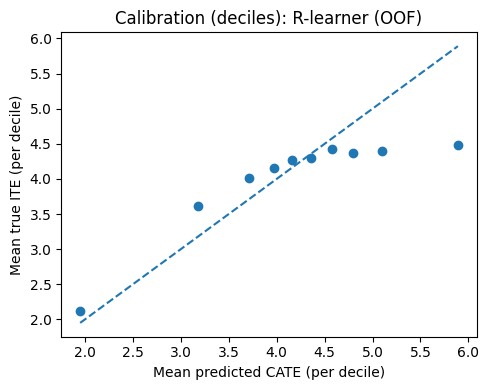

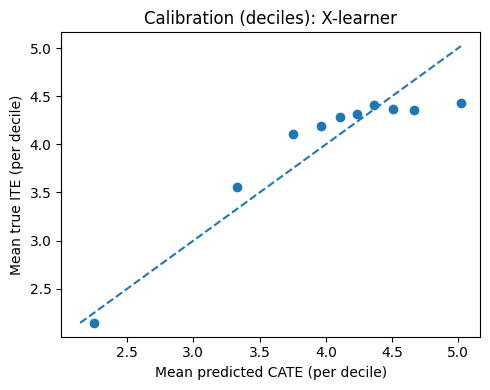

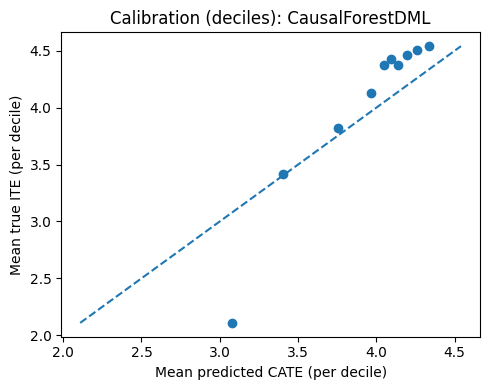

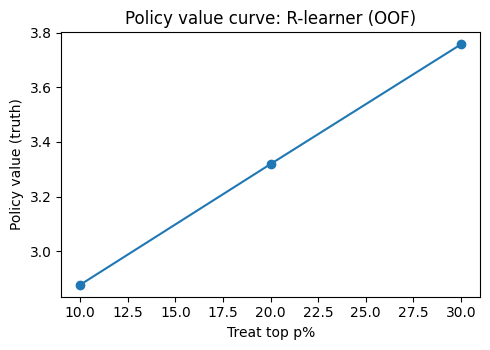

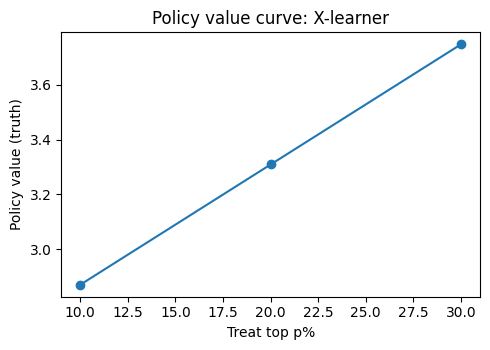

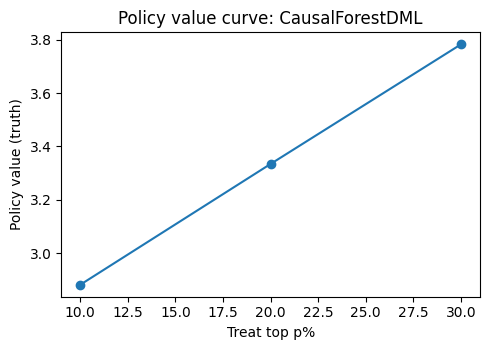

In [ ]:
# =============================
# R-learner (Nie & Wager, 2021) — OOF + comparison
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ---- If you already have these from your pipeline, you can remove duplicates ----
def calibration_by_quantiles(pred_ite: np.ndarray, true_ite: np.ndarray, q: int = 10):
    df = pd.DataFrame({"pred": pred_ite, "true": true_ite})
    df["decile"] = pd.qcut(df["pred"], q=q, labels=False, duplicates="drop")
    out = df.groupby("decile").agg(pred_mean=("pred", "mean"),
                                   true_mean=("true", "mean")).reset_index()
    return out

def policy_value_from_truth(pred_ite: np.ndarray, mu0: pd.Series, mu1: pd.Series, treat_fracs=(0.1,0.2,0.3)):
    mu0_arr, mu1_arr = mu0.values, mu1.values
    n = len(pred_ite)
    rows = []
    order = np.argsort(-pred_ite)  # descending
    for p in treat_fracs:
        k = max(1, int(np.floor(p*n)))
        treat_idx = order[:k]
        policy = np.zeros(n, dtype=int)
        policy[treat_idx] = 1
        value = np.mean(mu1_arr*policy + mu0_arr*(1-policy))
        none_value = np.mean(mu0_arr)
        all_value  = np.mean(mu1_arr)
        rand_value = (k/n)*all_value + (1-k/n)*none_value
        rows.append({
            "treat_frac": float(p),
            "policy_value": float(value),
            "gain_vs_none": float(value - none_value),
            "gain_vs_random": float(value - rand_value),
            "gain_vs_all": float(value - all_value)
        })
    return pd.DataFrame(rows)

# -----------------------------
# Core: R-learner with cross-fitting
# -----------------------------
def r_learner_oof(
    X: pd.DataFrame, T: pd.Series, Y: pd.Series,
    n_splits: int = 5,
    mu_model=None, e_model=None,
    tau_model="rf",    # "rf" (default) or "ridge"
    clip_eps: float = 1e-2,
    random_state: int = 42
):
    """
    Returns:
      tau_hat_oof: OOF CATE predictions (n,)
      tau_model_full: model fitted on full pseudo-outcome with weights
      info: dict of OOF diagnostics (means, etc.)
    """
    n = len(X)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Defaults for nuisance models
    if mu_model is None:
        mu_model = RandomForestRegressor(n_estimators=400, random_state=random_state)
    if e_model is None:
        e_model = RandomForestClassifier(n_estimators=400, random_state=random_state)

    mu_hat = np.zeros(n)
    e_hat  = np.zeros(n)

    # 1) Cross-fit mu and e (OOF)
    for tr_idx, te_idx in kf.split(X):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        T_tr, T_te = T.iloc[tr_idx], T.iloc[te_idx]
        Y_tr, Y_te = Y.iloc[tr_idx], Y.iloc[te_idx]

        mu_m = clone_estimator(mu_model)
        mu_m.fit(X_tr, Y_tr)
        mu_hat[te_idx] = mu_m.predict(X_te)

        e_m = clone_estimator(e_model)
        e_m.fit(X_tr, T_tr)
        e_hat[te_idx] = e_m.predict_proba(X_te)[:, 1]

    # 2) Build OOF pseudo-outcome + weights
    tilde_y = Y.values - mu_hat
    tilde_t = T.values - e_hat
    # clip to avoid division blow-ups
    denom   = np.where(np.abs(tilde_t) < clip_eps, np.sign(tilde_t)*clip_eps, tilde_t)
    Z       = tilde_y / denom
    W       = tilde_t**2

    # 3) Fit tau model OOF (for honest generalization) AND a final full model
    tau_hat_oof = np.zeros(n)

    # choose learner
    def make_tau_model():
        if tau_model == "rf":
            return RandomForestRegressor(n_estimators=400, min_samples_leaf=10, random_state=random_state)
        elif tau_model == "ridge":
            # Ridge with standardization; alpha via CV
            return Pipeline([
                ("sc", StandardScaler(with_mean=False)),  # sparse-safe; X is dense so ok either way
                ("ridge", RidgeCV(alphas=np.logspace(-3, 3, 13), fit_intercept=True))
            ])
        else:
            raise ValueError("tau_model must be 'rf' or 'ridge'.")

    for tr_idx, te_idx in kf.split(X):
        # IMPORTANT: re-estimate mu,e inside each fold if you want double cross-fitting.
        # Here we reuse OOF mu_hat/e_hat for simplicity (common practical variant).
        model_tau = make_tau_model()
        model_tau.fit(X.iloc[tr_idx].values, Z[tr_idx], sample_weight=W[tr_idx])
        tau_hat_oof[te_idx] = model_tau.predict(X.iloc[te_idx].values)

    # Final full model for downstream use
    tau_model_full = make_tau_model()
    tau_model_full.fit(X.values, Z, sample_weight=W)

    info = {
        "mu_hat_mean": float(np.mean(mu_hat)),
        "e_hat_mean": float(np.mean(e_hat)),
        "clip_eps": float(clip_eps)
    }
    return tau_hat_oof, tau_model_full, info

def clone_estimator(est):
    # minimal clone to keep this file self-contained
    import copy
    return copy.deepcopy(est)

# -----------------------------
# Driver: compare R vs X vs CausalForestDML
# -----------------------------
def run_rlearner_empirics():
    # --- Load IHDP (reuse your existing loader if present) ---
    X, T, Y, mu0, mu1 = load_data()  # from your pipeline

    # True ITE and ATE
    true_ite = (mu1 - mu0).values
    true_ate = float(np.mean(true_ite))

    # --- R-learner OOF ---
    r_oof, r_full_model, r_info = r_learner_oof(
        X, T, Y,
        n_splits=5,
        tau_model="rf",        # change to "ridge" to try penalized linear R-learner
        clip_eps=1e-2,
        random_state=42
    )
    r_ate  = float(np.mean(r_oof))
    r_bias = r_ate - true_ate
    r_rmse = float(np.sqrt(np.mean((r_oof - true_ite)**2)))

    # --- X-learner (econml) ---
    try:
        from econml.metalearners import XLearner
        x_learner = XLearner(models=RandomForestRegressor(n_estimators=400, random_state=42),
                             propensity_model=RandomForestClassifier(n_estimators=400, random_state=42))
        x_learner.fit(Y=Y.values, T=T.values, X=X.values)
        x_tau = x_learner.effect(X.values)
    except Exception as e:
        print("[WARN] XLearner failed:", e)
        x_tau = np.zeros(len(X))
    x_ate  = float(np.mean(x_tau))
    x_bias = x_ate - true_ate
    x_rmse = float(np.sqrt(np.mean((x_tau - true_ite)**2)))

    # --- CausalForestDML ---
    try:
        cf_res = fit_causal_forest(X, T, Y)   # from your pipeline
        cf_tau = cf_res.cates
    except Exception as e:
        print("[WARN] CausalForestDML failed:", e)
        cf_tau = np.zeros(len(X))
    cf_ate  = float(np.mean(cf_tau))
    cf_bias = cf_ate - true_ate
    cf_rmse = float(np.sqrt(np.mean((cf_tau - true_ite)**2)))

    # --- Print comparison table ---
    comp = pd.DataFrame({
        "Estimator": ["R-learner (OOF)", "X-learner", "CausalForestDML"],
        "ATE_hat":   [r_ate,             x_ate,       cf_ate],
        "True_ATE":  [true_ate,          true_ate,    true_ate],
        "Bias":      [r_bias,            x_bias,      cf_bias],
        "RMSE":      [r_rmse,            x_rmse,      cf_rmse]
    })
    # nice formatting
    with pd.option_context('display.float_format', '{:.4f}'.format):
        print("\n=== ATE/Bias/RMSE comparison (IHDP) ===")
        print(comp.to_string(index=False))

    # --- Calibration (deciles) for R, X, CF ---
    for name, tau in [("R-learner (OOF)", r_oof),
                      ("X-learner", x_tau),
                      ("CausalForestDML", cf_tau)]:
        cal = calibration_by_quantiles(tau, true_ite, q=10)
        print(f"\nOOF decile calibration — {name}:")
        with pd.option_context('display.float_format', '{:.4f}'.format):
            print(cal)

        # plot each calibration (optional save)
        plt.figure(figsize=(5.0, 4.0))
        plt.scatter(cal["pred_mean"], cal["true_mean"])
        lo = min(cal["pred_mean"].min(), cal["true_mean"].min())
        hi = max(cal["pred_mean"].max(), cal["true_mean"].max())
        plt.plot([lo, hi], [lo, hi], linestyle="--")
        plt.xlabel("Mean predicted CATE (per decile)")
        plt.ylabel("Mean true ITE (per decile)")
        plt.title(f"Calibration (deciles): {name}")
        plt.tight_layout()
        fname = f"calibration_deciles_{name.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '')}.png"
        plt.savefig(fname, dpi=150)
        print(f"Saved calibration plot -> {fname}")

    # --- Policy value curves using truth (treat top p%) ---
    print("\nPolicy value (treat-top-p%) using true (mu0, mu1):")
    for name, tau in [("R-learner (OOF)", r_oof),
                      ("X-learner", x_tau),
                      ("CausalForestDML", cf_tau)]:
        pol = policy_value_from_truth(tau, mu0, mu1, treat_fracs=(0.1, 0.2, 0.3))
        with pd.option_context('display.float_format', '{:.4f}'.format):
            print(f"\n{name}\n{pol}")

        # quick curve (optional)
        plt.figure(figsize=(5.0, 3.6))
        plt.plot(100*pol["treat_frac"], pol["policy_value"], marker='o')
        plt.xlabel("Treat top p%")
        plt.ylabel("Policy value (truth)")
        plt.title(f"Policy value curve: {name}")
        plt.tight_layout()
        curve_name = f"policy_curve_{name.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '')}.png"
        plt.savefig(curve_name, dpi=150)
        print(f"Saved policy curve -> {curve_name}")

    return {
        "comparison": comp,
        "r_tau_oof": r_oof,
        "x_tau": x_tau,
        "cf_tau": cf_tau
    }

# -----------------------------
# Run
# -----------------------------
if __name__ == "__main__":
    _ = run_rlearner_empirics()

In [ ]:
# fetch_401k_dataset_fixed.py
# ---------------------------
# Downloads the 401(k) dataset and saves CSV + Parquet.
# Instrument (Z): e401 | Treatment (D): p401 | Outcome (Y): net_tfa

import sys, subprocess

def ensure(pkg):
    try:
        __import__(pkg)
    except ImportError:
        print(f"[setup] Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# deps
ensure("doubleml")
ensure("pandas")
ensure("pyarrow")

import pandas as pd
from doubleml import datasets

print("[download] Fetching 401(k) dataset via DoubleML ...")
# Handle slight API differences across DoubleML versions gracefully
try:
    df = datasets.fetch_401K(return_type="DataFrame")  # modern API
except TypeError:
    # Older versions: try without keyword or with as_frame
    try:
        df = datasets.fetch_401K("DataFrame")
    except Exception:
        # Last resort: return as dict and convert
        data = datasets.fetch_401K()
        # Many versions return a dict with 'data' / 'target' etc.;
        # if already a DataFrame, this will just work:
        df = pd.DataFrame(data)

# Preview
key_cols = [c for c in ["e401","p401","net_tfa","inc","age","fsize","educ","marr","twoearn","pira","hown"]
            if c in df.columns]
print("\n[preview] first columns:", list(df.columns)[:15], "...")
if key_cols:
    print("[preview] key fields subset:\n", df[key_cols].head())
else:
    print("[preview] head:\n", df.head())

# Save
csv_path = "pension_401k.csv"
parquet_path = "pension_401k.parquet"
df.to_csv(csv_path, index=False)
df.to_parquet(parquet_path, index=False)
print(f"\n[saved] CSV     -> {csv_path}")
print(f"[saved] Parquet -> {parquet_path}")

# Minimal IV sanity checks
missing = df[["e401","p401","net_tfa"]].isna().sum() if set(["e401","p401","net_tfa"]).issubset(df.columns) else "N/A"
print("\n[checks] Missing values in (e401, p401, net_tfa):\n", missing)

print("\n[done] Dataset ready for IV (e.g., 2SLS: e401 → p401 → net_tfa).")

[setup] Installing doubleml ...
[download] Fetching 401(k) dataset via DoubleML ...

[preview] first columns: ['nifa', 'net_tfa', 'tw', 'age', 'inc', 'fsize', 'educ', 'db', 'marr', 'twoearn', 'e401', 'p401', 'pira', 'hown'] ...
[preview] key fields subset:
    e401  p401  net_tfa      inc  age  fsize  educ  marr  twoearn  pira  hown
0     0     0      0.0   6765.0   47      2     8     0        0     0     1
1     0     0   1015.0  28452.0   36      1    16     0        0     0     1
2     0     0  -2000.0   3300.0   37      6    12     0        0     0     0
3     0     0  15000.0  52590.0   58      2    16     1        1     0     1
4     0     0      0.0  21804.0   32      1    11     0        0     0     1

[saved] CSV     -> pension_401k.csv
[saved] Parquet -> pension_401k.parquet

[checks] Missing values in (e401, p401, net_tfa):
 e401       0
p401       0
net_tfa    0
dtype: int64

[done] Dataset ready for IV (e.g., 2SLS: e401 → p401 → net_tfa).


In [ ]:
# iv_2sls_401k_fixed.py
# ---------------------
# Outcome (Y): net_tfa
# Treatment (D, potentially endogenous): p401
# Instrument (Z): e401
# Controls (X): inc, age, fsize, educ, marr, twoearn, pira, hown

import sys, subprocess

def ensure(pkg):
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# deps
ensure("pandas")
ensure("numpy")
ensure("linearmodels")
ensure("statsmodels")  # for OLS baseline

import numpy as np
import pandas as pd
import statsmodels.api as sm
from linearmodels.iv import IV2SLS

# -------------------------------------------------
# 1. load + clean data
# -------------------------------------------------
df = pd.read_csv("pension_401k.csv")

keep = ["net_tfa","p401","e401","inc","age","fsize","educ","marr","twoearn","pira","hown"]
keep = [c for c in keep if c in df.columns]
df = df[keep].dropna().copy()

Y  = df["net_tfa"]
D  = df["p401"]                    # endogenous treatment
Z  = df[["e401"]]                  # instrument(s)
Xc = df[["inc","age","fsize","educ","marr","twoearn","pira","hown"]].astype(float)

# add constant for both models
X_with_const = sm.add_constant(Xc)        # const + controls
XZ_with_const = pd.concat([pd.Series(1, index=df.index, name="const"), Xc], axis=1)

n_obs = len(df)

# -------------------------------------------------
# 2. OLS baseline (treat p401 as exogenous)
# -------------------------------------------------
# OLS: net_tfa ~ const + controls + p401
X_ols = pd.concat([X_with_const, D], axis=1)
ols_model = sm.OLS(Y, X_ols)
ols_res = ols_model.fit(cov_type="HC1")   # robust SE

print("\n=== OLS (treats p401 as exogenous) ===")
print(ols_res.summary())

coef_ols = ols_res.params["p401"]
se_ols   = ols_res.bse["p401"]

# -------------------------------------------------
# 3. 2SLS / IV regression
# -------------------------------------------------
# IV2SLS syntax:
#   dependent = Y
#   exog      = const + controls        (purely exogenous vars)
#   endog     = D (the endogenous regressor)
#   instruments = Z (the instruments)
iv_model = IV2SLS(
    dependent=Y,
    exog=XZ_with_const,     # const + controls
    endog=D,
    instruments=Z
)

iv_res = iv_model.fit(cov_type="robust")  # heteroskedastic-robust SE

print("\n=== IV (2SLS) ===")
print(iv_res.summary)

coef_iv = iv_res.params["p401"]
se_iv   = iv_res.std_errors["p401"]

# -------------------------------------------------
# 4. First-stage diagnostics and weak-IV stats
# -------------------------------------------------
print("\n=== First-stage regression(s) ===")
print(iv_res.first_stage)  # shows p401 ~ const + controls + e401

# Weak instrument summary (if available in your linearmodels version)
try:
    weak_sum = iv_res.weak_instrument_summary
    print("\n=== Weak instrument summary ===")
    print(weak_sum)
except Exception:
    weak_sum = None
    print("\nweak_instrument_summary not available in this version of linearmodels.")

# If you add more than one instrument later, you can also use iv_res.overidentification_summary

# -------------------------------------------------
# 5. Pretty print the key numbers you'll paste into LaTeX
# -------------------------------------------------
print("\n========== KEY NUMBERS FOR REPORT ==========")
print(f"Sample size (n): {n_obs}")
print("\nOLS:")
print(f"  beta_OLS(p401): {coef_ols:.4f}")
print(f"  robust SE:       {se_ols:.4f}")

print("\n2SLS / IV:")
print(f"  beta_IV(p401):   {coef_iv:.4f}")
print(f"  robust SE:       {se_iv:.4f}")

# Extract first-stage F if available
first_stage_F = None
try:
    # linearmodels reports first-stage like a regression result;
    # for a single endogenous regressor, iv_res.first_stage is a dict keyed by that regressor.
    fs_obj = iv_res.first_stage['p401']
    # fs_obj has .f_stat for instrument(s) significance
    # but attribute names vary slightly across versions.
    if hasattr(fs_obj, 'f_stat'):
        first_stage_F = fs_obj.f_stat.stat
    elif hasattr(fs_obj, 'f_statistic'):
        first_stage_F = fs_obj.f_statistic.stat

    if first_stage_F is not None:
        print(f"\nFirst-stage F-stat (e401 -> p401): {float(first_stage_F):.3f}")
except Exception:
    print("\n[first-stage F not extracted automatically: check iv_res.first_stage manually]")

print("============================================\n")



=== OLS (treats p401 as exogenous) ===
                            OLS Regression Results                            
Dep. Variable:                net_tfa   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     117.5
Date:                Thu, 30 Oct 2025   Prob (F-statistic):          1.43e-210
Time:                        13:39:05   Log-Likelihood:            -1.2240e+05
No. Observations:                9915   AIC:                         2.448e+05
Df Residuals:                    9905   BIC:                         2.449e+05
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

# Load the data
df = pd.read_csv("pension_401k.csv")

# Define the variables
Y = df["net_tfa"]
T = df["p401"]
Z = df["e401"]
X = df[["inc", "age", "fsize", "educ", "marr", "twoearn", "pira", "hown"]]

# Add a constant for the intercept term
X_with_const = add_constant(X)

# First-stage regression: T = pi_0 + pi_1 Z + pi_2' X + v
first_stage_model = sm.OLS(T, sm.add_constant(pd.concat([Z, X], axis=1)))
first_stage_results = first_stage_model.fit()

# Get the fitted values (predicted treatment) from the first stage
T_hat = first_stage_results.fittedvalues

# Show the first few fitted values of T_hat
print(T_hat.head())

# You can also compare with the actual values of T
print(f"Actual Treatment (T):\n{T.head()}")

0   -0.016104
1   -0.009858
2   -0.035526
3   -0.012424
4    0.002889
dtype: float64
Actual Treatment (T):
0    0
1    0
2    0
3    0
4    0
Name: p401, dtype: int64


In [ ]:
# dmliv_401k_working_fixed.py
# -----------------------------------
# Goal:
#   Estimate heterogeneous (instrumented) treatment effects of 401(k) participation
#   using Double Machine Learning IV (DMLIV).
#
# Outcome  Y = net_tfa      (net financial assets)
# Treatmt  T = p401         (actually participates in 401(k))
# Instrmt  Z = e401         (eligible for 401(k))
# Covars   X = [inc, age, fsize, educ, marr, twoearn, pira, hown]

import sys, subprocess

def ensure(pkg):
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# dependencies
ensure("pandas")
ensure("numpy")
ensure("scikit-learn")
try:
    import econml  # noqa
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "econml"])

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from econml.iv.dml import DMLIV

# ----------------------
# 1. Load and prep data
# ----------------------
df = pd.read_csv("pension_401k.csv").dropna()

# core vars
Y = df["net_tfa"].astype(float).values          # outcome
T = df["p401"].astype(int).values               # treatment (binary: participates)
Z = df["e401"].astype(int).values               # instrument (binary: eligible)

feature_cols = ["inc", "age", "fsize", "educ", "marr",
                "twoearn", "pira", "hown"]
feature_cols = [c for c in feature_cols if c in df.columns]

# X: covariates we allow treatment effect to depend on (heterogeneity features)
X_mat = df[feature_cols].astype(float).values

# W: controls for the nuisance models; here we just reuse X
W_mat = X_mat.copy()

# ----------------------
# 2. Define nuisance models
# ----------------------
#   model_y_xw   ~ E[Y | X, W]
model_y_xw = RandomForestRegressor(
    n_estimators=400,
    random_state=42
)

#   model_t_xw   ~ E[T | X, W]
model_t_xw = RandomForestClassifier(
    n_estimators=400,
    random_state=42
)

#   model_t_xwz  ~ E[T | X, W, Z]
#   (how instrument Z shifts treatment take-up)
model_t_xwz = RandomForestClassifier(
    n_estimators=400,
    random_state=42
)

#   model_final: learns tau(X), the heterogeneous IV effect function
model_final = RandomForestRegressor(
    n_estimators=800,
    random_state=42
)

# ----------------------
# 3. Fit DMLIV
# ----------------------
dmliv = DMLIV(
    model_y_xw=model_y_xw,
    model_t_xw=model_t_xw,
    model_t_xwz=model_t_xwz,
    model_final=model_final,
    discrete_treatment=True,    # treatment is binary
    discrete_instrument=True,   # instrument is binary
    cv=3,
    random_state=42
)

# IMPORTANT:
# in this econml version, .fit() expects:
#   fit(Y, T, *, Z, X=None, W=None, ...)
# so Z MUST be passed by keyword, not positionally.
dmliv.fit(Y, T, Z=Z, X=X_mat, W=W_mat)

# ----------------------
# 4. Get heterogeneous IV-style effects
# ----------------------
# cate[i] is the estimated (local-IV) treatment effect for unit i with features X[i]
cate = dmliv.effect(X_mat).reshape(-1)

mean_cate = float(np.mean(cate))
sd_cate   = float(np.std(cate))
min_cate  = float(np.min(cate))
max_cate  = float(np.max(cate))

print("\n=== DMLIV RESULTS ===")
print(f"Mean IV-style CATE (≈ LATE among compliers): {mean_cate:.4f}")
print(f"SD of IV-style CATE: {sd_cate:.4f}")
print(f"Range of IV-style CATE: [{min_cate:.4f}, {max_cate:.4f}]")

# ----------------------
# 5. Feature importance for heterogeneity
# ----------------------
# econml exposes the final τ(x) model after fitting as .model_final_
final_model = getattr(dmliv, "model_final_", None)

if final_model is not None and hasattr(final_model, "feature_importances_"):
    fi = np.asarray(final_model.feature_importances_)
    order = np.argsort(-fi)

    print("\nTop heterogeneity drivers (which X features explain who benefits more):")
    for j in order[:min(8, len(order))]:
        print(f"  {feature_cols[j]}  importance={fi[j]:.3f}")
else:
    print("\n[Info] Couldn't extract feature importances from final model.")


/usr/local/lib/python3.12/dist-packages/econml/dml/dml.py:192: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  warn("The final model has a nonzero intercept for at least one outcome; "



=== DMLIV RESULTS ===
Mean IV-style CATE (≈ LATE among compliers): 12305.4661
SD of IV-style CATE: 39806.1606
Range of IV-style CATE: [-153156.1492, 352150.6355]

Top heterogeneity drivers (which X features explain who benefits more):
  age  importance=0.291
  fsize  importance=0.146
  marr  importance=0.144
  inc  importance=0.112
  educ  importance=0.110
  hown  importance=0.069


IndexError: list index out of range